## The shortest path problem using QUBO
This notebook implements a Perceval code for finding the shortest path on a _directed, weighted graph_ using the Quantum Unconstrained Binary
Optimization (QUBO) model. It is mainly adapted from https://ieeexplore.ieee.org/document/9186612, and represents the work done during the 2022 LOQCathon. 

Authors: Beata Zjawin, Benjamin Pointard, Nathan Claudet, Noé Delorme, Rina Ismailati

The task is to find the shortest path from start to finish (such that the sum of the weights is minimized) on a simple 5-edge graph:

![Alt text](graph_5edge.png)

Start with importing the necessary packages.


In [1]:
import perceval as pcvl
from perceval.components import PS, BS
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.rcdefaults()

## Implementation in Perceval
To find the shortest path, first we need to compute the objective function of the weighted graph. The constraints specified by the shortest path problem can be written in the form of quadratic penalty functions, as required by the QUBO formalism [1]:

\begin{align*}
H_s&=\Big(\sum_{j} x_{s,j} - \sum_{k} x_{k,s} - 1\Big)^2, \\
H_f&=\Big(\sum_{j} x_{f,j} - \sum_{k} x_{k,f} + 1\Big)^2, \\
H_i&=\Big(\sum_{j} x_{i,j} - \sum_{k} x_{k,i}\Big)^2. \\
\end{align*}

Here, $s$ and $f$ correspond to the start and finish node, respectively. Together with the original objective function:

\begin{equation*}
H_c= \sum_{(i,j)\in edges} c_{i,j} x^{2}_{i,j},
\end{equation*}

the constraints form the final QUBO objective function:

\begin{equation*}
H= \alpha \Big(H_s + H_f + \sum_{i \notin \{s,f\}} H_i\Big) + H_c,
\end{equation*}

where $\alpha$ is a scaling factor satisfying $\alpha > \sum_{(i,j)\in edges} c_{i,j}$.



For our simple example, the objective function is given by (see the Appendix to generate Hamiltonians from arbitrary adjacency matrices):


In [2]:
H1 = [[2., 32., -32., -32.,  32.,   0.],
      [0.,  1.,  32.,   0., -32., -32.],
      [0.,  0.,  35.,  32., -64., -32.],
      [0.,  0.,   0.,   2., -32.,  32.],
      [0.,  0.,   0.,   0.,  35.,  32.],
      [0.,  0.,   0.,   0.,   0.,   4.]]

Next, we implement a variational algorithm to find the optimal path using the QUBO model.

Following the approach introduced in Ref. [2], the output of the simulation, i.e. the Fock states |n> = |n_1,...,n_M>, can be mapped into bit strings $b=(b_1,...b_M)$ encoding possible paths on the graph by applying the parity function:

\begin{equation*}
\rho_j: b_i^{(j)} = \text{mod}[n_i,2] \oplus j.
\end{equation*}

For each evaluation, we need to test for $j=0$,  $j=1$, $n=M$ and $n=M−1$, as it is not possible to know a priori which configuration is the optimal one. Here, the number of modes, $M$, corresponds to the number of possible paths and $n$ is the number of photons.

In our example, $b=(b_{sa},b_{sb},b_{ab},b_{af},b_{ba},b_{bf})$, with $b_i \in \{0,1\}$, where subscripts correspond to graph edges.

In the cell below, we set up the functions necessary for the simulation, such as implementation of the parity function and sampling of the circuit.

In [3]:
def parify_samples(samples, j):
    """apply the parity function to the samples"""
    def _parity(output, j):
        m = len(output)
        parity = [0]*m
        for i in range(0,m):
            parity[i] = (output[i] + j) % 2
        return pcvl.BasicState(parity)
    
    new_samples = pcvl.BSDistribution()
    for idx,sample in enumerate(samples):
        new_sample = _parity(sample,j)
        if new_sample in new_samples:
            new_samples[_parity(sample,j)] += samples[sample]
        else:
            new_samples[_parity(sample,j)] = samples[sample]
    return new_samples
        
def set_parameters_circuit(parameters_circuit, values): 
    """set values of circuit parameters"""
    for idx, p in enumerate(parameters_circuit):
        parameters_circuit[idx].set_value(values[idx])

def compute_samples(circuit, input_state, nb_samples, j):
    """sample from the circuit"""
    p = pcvl.Processor("SLOS", circuit)
    p.with_input(input_state)
    p.min_detected_photons_filter(0)

    sampler = pcvl.algorithm.Sampler(p) 
    samples = sampler.sample_count(nb_samples)['results']
    
    return parify_samples(samples,j)

The central part of solving the shortest path problem with Perceval is initializing a universal circuit and optimizing its parameters. We will work with the following generic interferometer:

![Alt text](generic_6photon_interferometer.svg)

We sample the circuit for all configurations of $j$ and $n$. In this example, we set all the initial parameters to $\pi$, which is close to the optimal solution $-$ a good initial guess can dramatically improve simulation time. The loss function is given by

\begin{equation}
E(j;\theta,\psi) = \sum_{b^{(j)}} \beta_{b^{(j)}} <b_1^{(j)},...,b_M^{(j)}|H|b_1^{(j)},...,b_M^{(j)}>,
\end{equation}

where $\theta$ and $\psi$ stand for the parameters of the linear interferometer: beam-splitters and phase-shifters, respectively. For optimization, we use the Powell minimisation algorithm from the scipy.optimize package.

In [4]:
def test_configuration(circuit, nb_modes, j, n, H, nb_samples):
    """output the samples for a given configuration of j and n (inludes minimisation of the loss function)"""
    parameters_circuit = circuit.get_parameters()

    input_state = pcvl.BasicState([1]*nb_modes)
    if n!=nb_modes:
        input_state = pcvl.BasicState([1]*(nb_modes-1)+[0])

    def loss(parameters):
        set_parameters_circuit(parameters_circuit, parameters)
        samples = compute_samples(circuit, input_state, nb_samples, j)
        E = 0
        for sample in samples:
            b = np.array([sample[i] for i in range(len(sample))])
            b_prime = np.dot(H, b)
            E += samples[sample]/nb_samples*np.dot(b.conjugate(), b_prime)
            
        return np.real(E)

    # init_parameters = [2*(np.pi)*random.random() for _ in parameters_circuit] # initialize with random initial parameters
    init_parameters = [np.pi for _ in parameters_circuit] # initialize with a good guess
    best_parameters = minimize(loss, init_parameters, method='Powell', bounds=[(0,2*np.pi) for _ in init_parameters]).x    
    set_parameters_circuit(parameters_circuit, best_parameters)
    samples = compute_samples(circuit, input_state, nb_samples, j)
    return samples

def shortest_path(H, nb_samples):
    """run the universal circuit and optimize the parameters"""
    nb_modes = len(H)
    circuit = pcvl.Circuit.generic_interferometer(
        nb_modes,
        lambda i: BS(theta=pcvl.P(f"theta{i}"),phi_tr=pcvl.P(f"phi_tr{i}")),
        phase_shifter_fun_gen=lambda i: PS(phi=pcvl.P(f"phi{i}")))
    js = [0,1]
    ns = [nb_modes, nb_modes-1]
    configuration_samples = []
    for j in js:
        for n in ns:
            current_sample = test_configuration(circuit, nb_modes, j, n, H, nb_samples)
            print(f"Configuration for (j,n)=({j},{n})")
            print(current_sample)
            configuration_samples.append(([j,n],current_sample))
            
    return configuration_samples

Run the algorithm on 10000 samples (this may take a few minutes):

In [5]:
nb_samples = 10000
data = shortest_path(H1, nb_samples)

Configuration for (j,n)=(0,6)
{
  |0,0,0,0,0,0>: 11
  |0,1,0,0,0,1>: 6994
  |1,1,1,0,0,1>: 361
  |1,1,0,1,0,1>: 13
  |1,1,0,0,1,1>: 6
  |0,0,1,0,0,1>: 22
  |0,0,0,1,1,0>: 1
  |0,1,0,0,1,0>: 19
  |0,1,1,1,0,1>: 6
  |0,1,0,1,0,0>: 9
  |0,1,0,1,1,1>: 330
  |0,0,1,1,1,1>: 4
  |0,0,0,1,0,1>: 20
  |0,0,0,0,1,1>: 1
  |1,0,1,1,1,0>: 3
  |1,0,1,0,1,1>: 7
  |1,0,0,0,0,1>: 4
  |1,0,0,1,1,1>: 10
  |1,1,0,0,0,0>: 2
  |1,1,0,1,1,0>: 4
  |1,1,1,0,1,0>: 3
  |1,1,1,1,1,1>: 2101
  |1,0,1,1,0,1>: 2
  |0,1,1,0,0,0>: 5
  |0,1,1,1,1,0>: 1
  |0,1,1,0,1,1>: 50
}
Configuration for (j,n)=(0,5)
{
  |1,1,0,0,0,1>: 1
  |1,1,0,1,0,0>: 3
  |1,1,0,0,1,0>: 1
  |1,0,1,0,0,1>: 1
  |1,0,0,0,0,0>: 11
  |1,0,0,1,1,0>: 6
  |1,0,0,0,1,1>: 1
  |0,0,0,1,0,0>: 2
  |0,0,0,0,0,1>: 26
  |0,0,0,0,1,0>: 1
  |0,0,0,1,1,1>: 6
  |0,1,1,0,0,1>: 118
  |0,1,0,0,0,0>: 6330
  |0,1,0,1,1,0>: 3276
  |0,1,0,1,0,1>: 19
  |0,1,0,0,1,1>: 161
  |0,1,1,1,0,0>: 2
  |0,1,1,1,1,1>: 27
  |0,1,1,0,1,0>: 1
}
Configuration for (j,n)=(1,6)
{
  |0,0,1,1,0,0

Plot the results for better visualization:

In [6]:
def plot_samples(samples):
    
    values = list(samples.values())

    keys = samples.keys()

    key_list = []
    for x in keys:
        s = "".join(str(c) for c in list(x))
        key_list.append(s)

    y_pos = np.arange(len(key_list))
    barlist = plt.bar(y_pos, values, align='center', alpha=0.8)
    index = key_list.index('100100')
    barlist[index].set_color('m')
    plt.yscale('log')
    plt.xticks(y_pos, key_list)
    plt.xticks(rotation = 70)
    plt.ylabel('Sample values')
    plt.title('Sampling the Fock States')

    plt.show()

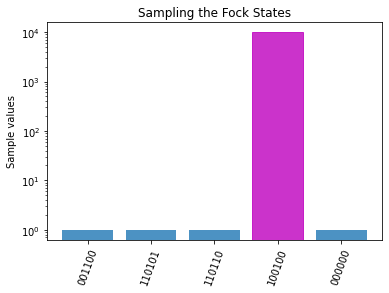

In [7]:
plot_samples(data[2][1]) # plot the samples for (j,n) = 1,6, i.e. the configuration which contains both a physical and minimum-energy solution

We can see that the best path is $b=(1,0,0,1,0,0)$, that is, the path $saf$.

## Bibliography
[1] Thomas Krauss and Joey McCollum. “Solving the Network Shortest Path Problem on a Quantum Annealer”. In: IEEE Transactions on Quantum Engineering 1 (2020), pp. 1–12. doi: 10.1109/TQE.2020.3021921.

[2] Kamil Bradler and Hugo Wallner. Certain properties and applications of
shallow bosonic circuits. 2021. doi: 10.48550/ARXIV.2112.09766. url:
https://arxiv.org/abs/2112.09766.

## Appendix
If you want to try more complicated graphs, this code generates the objective function for any weighted, directed graph:

In [8]:
def alpha_graph(graph): 
    """calculate alpha as sum of all the costs + 1"""
    alpha = 0 
    for i in range(0,len(graph)):
        for j in range(0,len(graph)):
            if graph[i][j] != 0 : alpha+=graph[i][j]
    return alpha+1

def graph_to_s(graph, s, weight):
    """calculate Hs"""
    ham = np.zeros((weight, weight))
    edges_coeff = [0]*weight
    constant_coeff = -1
    count = 0
    for i in range(0, len(graph)):
        for j in range(0, len(graph)):
            if graph[i][j] != 0 :
                if i == s:
                    edges_coeff[count] = 1
                if j == s:
                    edges_coeff[count] = -1
                count += 1
    
    for i in range(0, weight):
        for j in range(i+1, weight):
            ham[i][j] = edges_coeff[i]*edges_coeff[j]*2
            
    for i in range(0, weight):
        ham[i][i] += edges_coeff[i]*edges_coeff[i] + constant_coeff*edges_coeff[i]*2            

    return ham

def graph_to_f(graph, t, weight):
    """calculate Hf"""
    ham = np.zeros((weight, weight))
    edges_coeff = [0]*weight
    constant_coeff = +1
    count = 0
    for i in range(0,len(graph)):
        for j in range(0,len(graph)):
            if graph[i][j] != 0 :
                if i == t:
                    edges_coeff[count] = 1
                if j == t:
                    edges_coeff[count] = -1
                count += 1
    
    for i in range(0, weight):
        for j in range(i+1, weight):
            ham[i][j] = edges_coeff[i]*edges_coeff[j]*2
            
    for i in range(0,weight):
        ham[i][i] += edges_coeff[i]*edges_coeff[i] + constant_coeff*edges_coeff[i]*2              

    return ham

def graph_to_i(graph, our_i, weight):
    """calculate Hi"""
    ham = np.zeros((weight, weight))
    edges_coeff = [0]*weight
    count = 0
    for i in range(0, len(graph)):
        for j in range(0, len(graph)):
            if graph[i][j] != 0 :
                if i==our_i:
                    edges_coeff[count] = 1
                if j==our_i:
                    edges_coeff[count] = -1
                count += 1
    
    for i in range(0, weight):
        for j in range(i+1, weight):
            ham[i][j] = edges_coeff[i]*edges_coeff[j]*2 
            
    for i in range(0, weight):
        ham[i][i] += edges_coeff[i]*edges_coeff[i]

    return ham

def graph_to_c(graph, weight):
    """calculate Hc"""
    ham = np.zeros((weight, weight))
    count = 0
    for i in range(0,len(graph)):
        for j in range(0,len(graph)):
            if graph[i][j] != 0 :
                ham[count][count] = graph[i][j]
                count += 1

    return ham

def graph_to_hamiltonian(graph,s,f): 
    """returns the graph adjacency matrix as a Hamiltonian"""
    weight = np.count_nonzero(graph)
    ham =  np.zeros((weight, weight))
    alpha = alpha_graph(graph)
    ham += alpha*graph_to_s(graph, s, weight)
    ham += alpha*graph_to_f(graph, f, weight)
    for i in range(0,weight):
        if i!=s and i!=f:
            ham += alpha*graph_to_i(graph, i, weight)
    ham += graph_to_c(graph, weight)

    return ham

In [9]:
"""example: our 5-edge graph"""
# start,a,b,finish -> 0,1,2,3
G1 = np.array([[0,2,1,0], [0,0,3,2], [0,3,0,4], [0,0,0,0]]) # weights associated to all possible paths
G1_s = 0 # start index
G1_f = 3 # finish index
H_example = graph_to_hamiltonian(G1, G1_s, G1_f)
print(H_example)

[[  2.  32. -32. -32.  32.   0.]
 [  0.   1.  32.   0. -32. -32.]
 [  0.   0.  35.  32. -64. -32.]
 [  0.   0.   0.   2. -32.  32.]
 [  0.   0.   0.   0.  35.  32.]
 [  0.   0.   0.   0.   0.   4.]]
